In [14]:
"""define model
"""
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class stp(nn.Module):
    def __init__(self):
        super(stp, self).__init__()
#         self.opt = options

        ##embedding for the coordinates
        self.linear_embedding = nn.Linear(2,16) #input_features, output_features
        
        ##feature encoder
        # self.GRU = nn.GRU(input_size= self.opt.emb_output_features, hidden_size= self.opt.enc_output_features, num_layers = 1, batch_first = True)
        # self.ego_GRU = nn.GRU(input_size= self.opt.emb_output_features, hidden_size= self.opt.ego_enc_output_features, num_layers = 1, batch_first = True)
        self.LSTM = nn.LSTM(input_size= 16, hidden_size= 32, num_layers = 1, batch_first = True)
        # self.ego_LSTM = nn.LSTM(input_size= self.opt.emb_output_features, hidden_size= self.opt.ego_enc_output_features, num_layers = 1, batch_first = True)
        
        self.encoder_embedding = nn.Linear(32, 32)
        # self.ego_encoder_embedding = nn.Linear(self.opt.ego_enc_output_features,128)
        ##graph NN convolution
        self.conv1 = GATConv(in_channels= 32,out_channels= 32 ,heads= 4,add_self_loops = False)
        self.conv2 = GATConv(in_channels= 4*32,out_channels= 32,heads= 4,add_self_loops = False)
        
        ##fully connected layer
        self.conv_embedding = nn.Linear(4*32,32)
        self.fcl1 = nn.Linear(64,2)
        # self.fcl2 = nn.Linear(32,2)
        
        ##decoder
        self.decoder = nn.LSTM(input_size= 64, hidden_size= 64 , num_layers= 2, batch_first = True)

        #activation
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, input, device):
        """pass a batch to the network and compute losses
        """
        self.device = device
        input.to(self.device)
        x = input.x #shape:(N,30,2)
        edge_index = input.edge_index #(2,X)
        target_index = torch.tensor([(input.batch==i).nonzero()[0] for i in range(input.num_graphs)]) #input.num_graphs = batch_size
        # final_x = torch.empty([input.num_graphs,10,128], dtype = torch.float32).to(self.device)
        #emb
        encoder_x = self.linear_embedding(x) #from (N,30,2) to (N,30,16)
        encoder_x = self.relu(encoder_x)
        # _,hn = self.GRU(x)
        # x = self.relu(hn)
        _,(hn,cn) = self.LSTM(encoder_x)
        encoder_x = self.relu(cn) #(1,N,hidden_size), hidden_size = 32
        encoder_x = encoder_x.squeeze(0)#(N,32)
        encoder_x = self.encoder_embedding(encoder_x) #(N,32)
        encoder_x = self.relu(encoder_x)
        conv_x = self.conv1(encoder_x,edge_index) #(N,128)
        conv_x = self.relu(conv_x)
        conv_x = self.conv2(conv_x,edge_index) #(N,128)
        conv_x = self.relu(conv_x)
        conv_x = self.conv_embedding(conv_x) #(N,32)
        conv_x = self.relu(conv_x)

        #ego_emb
        # ego_x = input.x[target_index] #(N,30,2)
        # ego_x = self.linear_embedding(ego_x) #(N,30,16)
        # ego_x = self.relu(ego_x)
        # _, ego_x = self.ego_GRU(ego_x)
        # _, (h_ego,c_ego) = self.ego_LSTM(ego_x)
        # ego_x = self.relu(c_ego).squeeze(0) #(N,64)
        # ego_x = self.ego_encoder_embedding(ego_x) #(N,128)
        #interchange input.num_graphs to 1
        # for i in range(input.num_graphs):
        #     index = [torch.flatten((input.batch==i).nonzero())][0].tolist()
        #     tmp_x = x[index[0]:index[-1]+1]
        #     tmp_ego_x = ego_x[i].unsqueeze(0)
        #     #combined_x with N = 50
        #     tmp_x = torch.cat((tmp_ego_x,tmp_x), axis = 0)
        #     #calculating the number of repetition
        #     num_of_repetition = 50//tmp_x.shape[0]
        #     #calculating the number of appending needed to reach 50
        #     num_of_append = 50%tmp_x.shape[0]
        #     tmp_x = tmp_x.repeat(num_of_repetition,1)
        #     for j in range(0,num_of_append):
        #         tmp_x = torch.cat((tmp_ego_x,tmp_x), axis=0) #(50,64)
        #     tmp_x = tmp_x.unsqueeze(0) #(1,50,64)
        #     final_x[i,:,:] = tmp_x
        #extract the ego vehicle from the input 
        fwd_ego_x = encoder_x[target_index] #(N,32)

        fwd_conv_x = conv_x[target_index]

        decoder_x = torch.cat((fwd_ego_x, fwd_conv_x), 1)

        decoder_x = decoder_x.unsqueeze(1) #(N,1,64)

        final_x = decoder_x.repeat(1,50,1)

        #decoder
        pred, (hn, cn) = self.decoder(final_x)
        pred = self.fcl1(pred)
        pred = self.relu(pred)
        # pred = self.fcl2(pred)
        # pred = self.relu(pred)
        return pred


In [27]:
"""utils
"""
import torch
import pickle
from torch_geometric.data import Dataset

def read_file(path):
  with open(path,'r') as tmp:
    filepaths = tmp.read().splitlines()
    return filepaths

def compute_losses(pred, gt):
    pred_x = pred[:,:,0]
    pred_y = pred[:,:,1]
    gt_x = gt[:,:,0]
    gt_y = gt[:,:,1]
    batch_size = gt_y.shape[0]
    RMSE = torch.sqrt(torch.mean(20*torch.pow((pred_x-gt_x),2) + 0.5*torch.pow((pred_y-gt_y),2)))
    RMSE = RMSE.cpu().item()
    return RMSE


def pickle_loader(path):
  with open(path,'rb') as tmp_file:
    data = pickle.load(tmp_file)
  return data

def torch_loader(path):
  data = torch.load(path)
  return data

class trajectory_data(Dataset):
  def __init__(self, file_path):
    self.file_path =file_path

  def __len__(self):
    return len(self.file_path)
  
  def __getitem__(self, idx):
    load_path = self.file_path[idx]
    # pyg_data = pickle_loader(load_path)
    ##################################
    pyg_data = torch_loader(load_path)
    pyg_data.x = pyg_data.node_feature.type(torch.FloatTensor)
    pyg_data.y = pyg_data.y.type(torch.FloatTensor)
    ##################################
    # x = pyg_data.x
    # y = pyg_data.y
    # edge_index = pyg_data.edge_index
    return pyg_data

In [28]:
"""visualiser
"""
import matplotlib.pyplot as plt
import numpy as np

def plot_result(data, fut_pred):
    data= data.to("cpu")
    his_coor_list = data.x
    fut_coor_list = data.y
    count = 0
    fig,ax = plt.subplots(figsize = (10,2))
    for num in range(data.x.shape[0]):
        his = his_coor_list[num].numpy()

        fut = fut_coor_list[0].numpy()
        if count == 0:
            his_x = his[:,0]
            his_y = his[:,1]
            fut_x = fut[:,0]
            fut_y = fut[:,1]
            count += 1
            ax.plot(his_y,his_x, color = "red", lw = 3)
            ax.plot(fut_y,fut_x, color = "blue", ls = "--", lw = 3)
        else:
            full_coor = his
            x = full_coor[:,0]
            y = full_coor[:,1]
            ax.plot(y,x,color = "grey")
    fut_pred = fut_pred.to("cpu")
    fut_pred = fut_pred.numpy()
    # print(pred.shape)
    print(fut_pred.shape)
    fut_pred = np.squeeze(fut_pred,0)
    print(fut_pred.shape)
    pred_x = fut_pred[:,0]
    pred_y = fut_pred[:,1]
    ax.plot(pred_y,pred_x,lw=2,color = "green")
    print('showing plot')
    plt.show()
    ax.cla()

Loading model from /home/jayden99/Desktop/URECA/models/03052022_no_downsampling.pth
Loading pretrained model
-- Predicting on 5999 test samples
evaluating
(1, 50, 2)
(50, 2)
showing plot


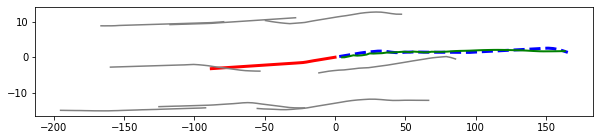

average_losses: 1.921985387802124


In [35]:
"""evaluation
"""
import torch
from torch_geometric.loader import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#load model
model_path = "/home/jayden99/Desktop/URECA/models/03052022_no_downsampling.pth"
print("Loading model from",model_path)
print("Loading pretrained model")
model = stp()
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

#loading data
test_docpath = "/home/jayden99/Desktop/URECA/dataset/test_xy.txt"
test_fpath_list = read_file(test_docpath)
print("-- Predicting on %s test samples"%len(test_fpath_list))
test_dataset = trajectory_data(test_fpath_list)
test_generator = DataLoader(test_dataset, 1, shuffle = True,pin_memory = True, num_workers = 4)

model.eval()
with torch.no_grad():
    print("evaluating")
    losses = 0
    for i, data in enumerate(test_generator):
        pred = model(data, device)
        gt = data.y.to(device)
        losses += compute_losses(pred,gt)
        plot_result(data, pred)
        break
avg_losses = losses
print(" ".join(["average_losses:",str(avg_losses)]))

In [9]:
%load_ext tensorboard
%tensorboard --logdir /home/jayden99/Desktop/URECA/test

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
